In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings

warnings.filterwarnings('ignore')

seed = 42

In [3]:
df = pd.read_csv('data.csv')

In [4]:
columns = ['Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders', 'Vehicle Style', 'highway MPG',
           'city mpg', 'MSRP', 'Transmission Type']
df = df[columns]
df

,Make,Model,Year,Engine HP,Engine Cylinders,Vehicle Style,highway MPG,city mpg,MSRP,Transmission Type
0,BMW,1 Series M,2011,335.0,6.0,Coupe,26,19,46135,MANUAL
1,BMW,1 Series,2011,300.0,6.0,Convertible,28,19,40650,MANUAL
2,BMW,1 Series,2011,300.0,6.0,Coupe,28,20,36350,MANUAL
3,BMW,1 Series,2011,230.0,6.0,Coupe,28,18,29450,MANUAL
4,BMW,1 Series,2011,230.0,6.0,Convertible,28,18,34500,MANUAL
...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,300.0,6.0,4dr Hatchback,23,16,46120,AUTOMATIC
11910,Acura,ZDX,2012,300.0,6.0,4dr Hatchback,23,16,56670,AUTOMATIC
11911,Acura,ZDX,2012,300.0,6.0,4dr Hatchback,23,16,50620,AUTOMATIC
11912,Acura,ZDX,2013,300.0,6.0,4dr Hatchback,23,16,50920,AUTOMATIC


In [5]:
df.columns = df.columns.str.replace(' ', '_').str.lower()
df.fillna(0)
df = df.rename(columns={'msrp': 'price'})

# Question 1

In [67]:
# df.groupby('transmission_type').count()
print('q1:', df['transmission_type'].value_counts().idxmax())

q1: AUTOMATIC


# Question 2

In [68]:
df.head(5).T

,0,1,2,3,4
make,BMW,BMW,BMW,BMW,BMW
model,1 Series M,1 Series,1 Series,1 Series,1 Series
year,2011,2011,2011,2011,2011
engine_hp,335.0,300.0,300.0,230.0,230.0
engine_cylinders,6.0,6.0,6.0,6.0,6.0
vehicle_style,Coupe,Convertible,Coupe,Coupe,Convertible
highway_mpg,26,28,28,28,28
city_mpg,19,19,20,18,18
price,46135,40650,36350,29450,34500
transmission_type,MANUAL,MANUAL,MANUAL,MANUAL,MANUAL


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   make               11914 non-null  object 
 1   model              11914 non-null  object 
 2   year               11914 non-null  int64  
 3   engine_hp          11845 non-null  float64
 4   engine_cylinders   11884 non-null  float64
 5   vehicle_style      11914 non-null  object 
 6   highway_mpg        11914 non-null  int64  
 7   city_mpg           11914 non-null  int64  
 8   price              11914 non-null  int64  
 9   transmission_type  11914 non-null  object 
dtypes: float64(2), int64(4), object(4)
memory usage: 930.9+ KB


In [71]:
numerical_columns = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'year']
categorical_columns = ['make', 'model', 'vehicle_style', 'transmission_type']

In [72]:
df[numerical_columns].corrwith(df.price).sort_values(ascending=False)

engine_hp           0.662008
engine_cylinders    0.531312
year                0.227590
city_mpg           -0.157676
highway_mpg        -0.160043
dtype: float64

In [73]:
print('q2: engine_hp and engine_cylinders')

q2: engine_hp and engine_cylinders


# Question 3

In [9]:
average = df.price.mean()
df['above_average'] = df['price'] > average

In [76]:
from sklearn.model_selection import train_test_split

df_train_valid, df_test = train_test_split(df, test_size=0.2, random_state=seed)
df_train, df_valid = train_test_split(df_train_valid, test_size=0.25, random_state=seed)

y_train = df_train.above_average
y_valid = df_valid.above_average
y_test = df_test.above_average

df_train.drop(columns=['above_average', 'price'], inplace=True)
df_valid.drop(columns=['above_average', 'price'], inplace=True)
df_test.drop(columns=['above_average', 'price'], inplace=True)

In [78]:
from sklearn.metrics import mutual_info_score


def calculate_mutual_info(x, y):
    return mutual_info_score(x, y)


df_train_mi = df_train[categorical_columns].apply(lambda x: calculate_mutual_info(x, y_train))

In [79]:
print('q3: ', df_train_mi.idxmin())

q3:  transmission_type


# Question 4

In [14]:
from sklearn.feature_extraction import DictVectorizer


def get_one_hot_encoder(df: pd.DataFrame) -> DictVectorizer:
    dictionary = df.to_dict(orient='records')
    vectorizer = DictVectorizer(sparse=False)
    vectorizer.fit(dictionary)
    return vectorizer


def to_model_input(df: pd.DataFrame, encoder: DictVectorizer):
    df_copy = df.copy()
    df_copy.fillna(0, inplace=True)
    dictionary = df_copy.to_dict(orient='records')
    x = encoder.transform(dictionary)
    return x


def calc_accuracy(y_predict, y_actual) -> float:
    return (y_predict == y_actual).mean()

In [81]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
encoder = get_one_hot_encoder(df_train)
x_train = to_model_input(df_train, encoder)
model.fit(x_train, y_train)
x_valid = to_model_input(df_valid, encoder)
y_predict = model.predict(x_valid)
accuracy = calc_accuracy(y_predict, y_valid)
print('q4:', round(accuracy, 2))

q4: 0.94


# Question 5

In [82]:
df_train[numerical_columns].corrwith(y_train)

engine_hp           0.673478
engine_cylinders    0.452054
highway_mpg        -0.127142
city_mpg           -0.155754
year                0.315195
dtype: float64

In [83]:
df_train_mi

make                 0.239769
model                0.462344
vehicle_style        0.084143
transmission_type    0.020958
dtype: float64

In [84]:
def get_accuracy_from_logistic_regression(df_train, df_valid):
    model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=seed)
    encoder = get_one_hot_encoder(df_train)
    x_train = to_model_input(df_train, encoder)
    model.fit(x_train, y_train)
    x_valid = to_model_input(df_valid, encoder)
    y_predict = model.predict(x_valid)
    return calc_accuracy(y_predict, y_valid)

In [85]:
for numerical_feature in numerical_columns:
    new_numerical_columns = numerical_columns.copy()
    new_numerical_columns.remove(numerical_feature)
    new_columns = new_numerical_columns + categorical_columns
    new_accuracy = get_accuracy_from_logistic_regression(df_train[new_columns], df_valid[new_columns])
    print(
        f'accuracy of removing {numerical_feature}: {round(new_accuracy, 3)};\t {round(accuracy - new_accuracy, 5)} less than prev model')

for categorical_feature in categorical_columns:
    new_categorical_columns = categorical_columns.copy()
    new_categorical_columns.remove(categorical_feature)
    new_columns = numerical_columns + new_categorical_columns
    new_accuracy = get_accuracy_from_logistic_regression(df_train[new_columns], df_valid[new_columns])
    print(
        f'accuracy of removing {categorical_feature}: {round(new_accuracy, 3)};\t {round(accuracy - new_accuracy, 5)} less than prev model')

accuracy of removing engine_hp: 0.924;	 0.02056 less than prev model
accuracy of removing engine_cylinders: 0.947;	 -0.00252 less than prev model
accuracy of removing highway_mpg: 0.941;	 0.00336 less than prev model
accuracy of removing city_mpg: 0.932;	 0.01217 less than prev model
accuracy of removing year: 0.947;	 -0.00252 less than prev model
accuracy of removing make: 0.944;	 0.00042 less than prev model
accuracy of removing model: 0.916;	 0.02854 less than prev model
accuracy of removing vehicle_style: 0.936;	 0.00839 less than prev model
accuracy of removing transmission_type: 0.947;	 -0.0021 less than prev model


In [87]:
print(
    'q5: transmission_type')  # based on both removing features and recalculating accuracy and also based on mutual information

q5: transmission_type


# Question 6

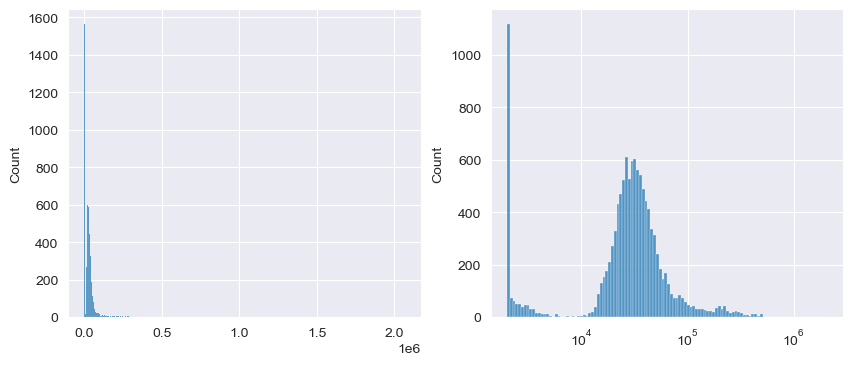

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# plot the histograms on separate subplots
sns.histplot(df.price.values, ax=axs[0])
sns.histplot(df.price.values, ax=axs[1], log_scale=True)

# show the plot
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

df_train_valid, df_test = train_test_split(df, random_state=seed, test_size=0.2)
df_train, df_valid = train_test_split(df_train_valid, random_state=seed, test_size=0.25)

y_train = np.log1p(df_train.price)
y_valid = np.log1p(df_valid.price)
y_test = np.log1p(df_test.price)

df_train.drop(columns=['above_average', 'price'], inplace=True)
df_valid.drop(columns=['above_average', 'price'], inplace=True)
df_test.drop(columns=['above_average', 'price'], inplace=True)

In [11]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


def get_rmse_from_ridge_regression(alpha: float) -> float:
    model = Ridge(solver='sag', alpha=alpha, random_state=seed)
    encoder = get_one_hot_encoder(df_train)
    x_train = to_model_input(df_train, encoder)
    model.fit(x_train, y_train)
    x_valid = to_model_input(df_valid, encoder)
    y_predict = model.predict(x_valid)
    return mean_squared_error(y_valid, y_predict)

In [15]:
for alpha in [0, 0.01, 0.1, 1, 10]:
    rmse = get_rmse_from_ridge_regression(alpha)
    print(f'alpha:{alpha}, \t rmse:{round(rmse, 3)}')

alpha:0, 	 rmse:0.237
alpha:0.01, 	 rmse:0.237
alpha:0.1, 	 rmse:0.237
alpha:1, 	 rmse:0.237
alpha:10, 	 rmse:0.237
